# Microstructure Identification

### High strength carbon steels microstructure classifier with convolutional neural networks

Data Sourses: CMU UHCSDB http://uhcsdb.materials.cmu.edu/


In [1]:
import numpy as np
import pandas as pd
import keras
from keras.utils import np_utils # label to categorical

# read xlsx file for label and image path
filename= './Input/micrograph.xlsx'
dataread=pd.read_excel(filename,'micrograph',index_col=None, na_values=['NA'])
head=dataread.columns.values.tolist()
micro_id=dataread["micrograph_id"].values.tolist()
micro_constituents=dataread["primary_microconstituent"].values.tolist()
micro_paths=dataread["path"].values.tolist()
micro_files=["./Input/micrograph/"+i[0:-4]+"[cropped].tif" for i in micro_paths]

# encoding the label 
labelmap={'martensite':0,'network':1,'pearlite':2,'spheroidite':3,'pearlite+spheroidite':4,'pearlite+widmanstatten':5,'spheroidite+widmanstatten':6}
micro_constituents_label = [labelmap[i] for i in micro_constituents]
micro_targets=np_utils.to_categorical(np.array(micro_constituents_label), 7)

# split files into training, validation, and test
train_files=micro_files[0:700]
valid_files=micro_files[700:850]
test_files=micro_files[850:]

train_targets=micro_targets[0:700]
valid_targets=micro_targets[700:850]
test_targets=micro_targets[850:]

# print statistics about the dataset
print('There are %d total microstructure categories.' % len(labelmap))
print('There are %s total microstructure images.\n' % len(micro_targets))
print('There are %d training microstructure images.' % len(train_targets))
print('There are %d validation microstructure images.' % len(valid_targets))
print('There are %d test microstructure images.'% len(test_targets))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 7 total microstructure categories.
There are 961 total microstructure images.

There are 700 training microstructure images.
There are 150 validation microstructure images.
There are 111 test microstructure images.


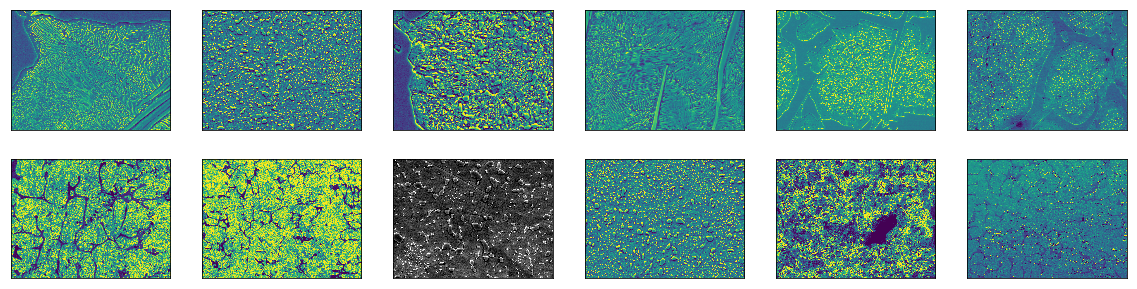

In [2]:
# Visualize the microstructure features
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[])
    img = mpimg.imread(train_files[i])
    ax.imshow(np.squeeze(img))

## Create a CNN to Classify Microstructure (using Transfer Learning)

### Step1: Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D tensor as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $645 \times 484$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 645, 484, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 645, 484, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def feature_to_tensor(img_path,model):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(645,484))
    # convert PIL.Image.Image type to 3D tensor with shape (645, 484, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 645, 484, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    features = model.predict(x)
    return features

def features_to_tensor(img_paths,model):
    list_of_tensors = [feature_to_tensor(img_path,model) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Step2: Obtain Bottleneck Features 

In [4]:
from keras.applications.resnet50 import ResNet50
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

base_model = ResNet50(weights='imagenet', include_top=False)
train_ResNet50 = features_to_tensor(train_files,base_model)
valid_ResNet50  = features_to_tensor(valid_files,base_model)
test_ResNet50  = features_to_tensor(test_files,base_model)

100%|██████████| 111/111 [00:07<00:00, 13.93it/s]


### Step3: Model Architecture

The model uses the the pre-trained ResNet50 model as a fixed feature extractor, where the last convolutional output of ResNet50 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [5]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

ResNet50_model = Sequential()
ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet50_model.add(Dense(7, activation='softmax'))
ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 14,343
Trainable params: 14,343
Non-trainable params: 0
_________________________________________________________________


### Step4: Compile the Model and Train the Model

In [6]:
ResNet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpointer = keras.callbacks.ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=0, save_best_only=True)

hist = ResNet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=100, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 700 samples, validate on 150 samples
Epoch 1/100
700/700 [==============================] - 3s 5ms/step - loss: 1.0225 - acc: 0.6714 - val_loss: 0.4884 - val_acc: 0.8333
Epoch 2/100
700/700 [==============================] - 3s 4ms/step - loss: 0.4827 - acc: 0.8514 - val_loss: 0.4524 - val_acc: 0.8400
Epoch 3/100
700/700 [==============================] - 3s 4ms/step - loss: 0.3703 - acc: 0.8829 - val_loss: 0.3503 - val_acc: 0.8867
Epoch 4/100
700/700 [==============================] - 3s 4ms/step - loss: 0.3098 - acc: 0.9014 - val_loss: 0.3202 - val_acc: 0.8867
Epoch 5/100
700/700 [==============================] - 3s 4ms/step - loss: 0.2571 - acc: 0.9286 - val_loss: 0.3003 - val_acc: 0.9000
Epoch 6/100
700/700 [==============================] - 3s 4ms/step - loss: 0.2196 - acc: 0.9343 - val_loss: 0.2886 - val_acc: 0.9067
Epoch 7/100
700/700 [==============================] - 3s 4ms/step - loss: 0.2070 - acc: 0.9300 - val_loss: 0.3134 - val_acc: 0.8533
Epoch 8/100
700/700 [==

Epoch 62/100
700/700 [==============================] - 3s 4ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.4232 - val_acc: 0.8933
Epoch 63/100
700/700 [==============================] - 3s 4ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4357 - val_acc: 0.9000
Epoch 64/100
700/700 [==============================] - 3s 4ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4277 - val_acc: 0.8867
Epoch 65/100
700/700 [==============================] - 3s 4ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4506 - val_acc: 0.8933
Epoch 66/100
700/700 [==============================] - 3s 4ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4051 - val_acc: 0.9067
Epoch 67/100
700/700 [==============================] - 3s 4ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4460 - val_acc: 0.9000
Epoch 68/100
700/700 [==============================] - 3s 4ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.4613 - val_acc: 0.8933
Epoch 69/100
700/700 [==============================] - 3s 4ms

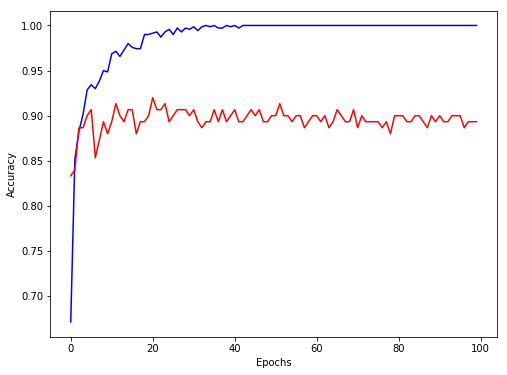

In [7]:
import  matplotlib.pyplot as plt
% matplotlib inline
plt.figure().set_size_inches(8,6)
plt.plot(hist.history['acc'],'b');plt.plot(hist.history['val_acc'],'r')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

### Step5: Load the Model with the Best Validation Loss and Test the Model

In [8]:
ResNet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')
ResNet50_predictions = [np.argmax(ResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 94.5946%
